In [1]:
%matplotlib inline

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
PATH = Path('data')

from itertools import product
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


from sklearn.tree import export_graphviz
import IPython,graphviz
from IPython.display import display
import re

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def ip2country(ip):
    ctry = df_country.loc[(df_country.lower_bound_ip_address <= ip) & (ip<=df_country.upper_bound_ip_address),'country'].values
    if len(ctry)==0: return 'NaN'
    if len(ctry)>1: raise ValueError('IP to Country is not 1 to 1')
    return ctry[0]

def date_breakdown(df,cols,drop=True):
    if not isinstance(cols,list):
        cols = [cols]
    for col in cols:
        df[col+'_day'] = df[col].dt.day
        df[col+'_month'] = df[col].dt.month
        df[col+'_dayofweek'] = df[col].dt.dayofweek
        df[col+'_hour'] = df[col].dt.hour
        df[col+'_minute']=df[col].dt.minute
        df[col+'_second']=df[col].dt.second
        if drop: df.drop(col,axis=1,inplace=True)
def get_data():
    df = pd.read_csv(PATH/'Fraud_Data_Country.csv',parse_dates=['signup_time','purchase_time'])
    df.country.fillna('NaN',inplace=True)
    df=df.sort_values(['signup_time','purchase_time']).reset_index(drop=True)
    df.drop(['ip_address','user_id'],axis=1,inplace=True)
    df['day_old'] = (df.purchase_time-df.signup_time) / np.timedelta64(1,'D')
    date_breakdown(df,['signup_time','purchase_time'],drop=True)   
    return df

def prepare_data_rf(cat_cols,nan_cols=[],cols_to_drop=[]):
    df = get_data()
    cat_class={}
    for col in cat_cols:
        print(f'Process:{col}')
        if col in nan_cols: df[f'{col}_isnull'] = (df[col]=='NaN').astype(np.uint8)
        le = LabelEncoder()
        df[col]=le.fit_transform(df[col])
        cat_class[col]=le.classes_.tolist()
    
    y = df['class']
    df.drop('class',axis=1,inplace=True)
    if len(cols_to_drop): df.drop(cols_to_drop,axis=1,inplace=True)
    col_names = df.columns.values
    
    return np.array(df,dtype=np.float32),np.array(y,dtype=np.float32),cat_class,col_names

def print_metrics(y_train,y_pred_train,y_val,y_pred_val):
    print(f'Train AUC: {roc_auc_score(y_train,y_pred_train[:,1])}. Train Log loss: {log_loss(y_train,y_pred_train)}')
    print(f'Val AUC: {roc_auc_score(y_val,y_pred_val[:,1])}. Val Log loss: {log_loss(y_val,y_pred_val)}')
def train_rf(X_train,y_train,X_val,y_val,params):
    rf = RandomForestClassifier(random_state=1402,n_jobs=-1,**params)
    rf.fit(X_train,y_train)
    y_pred_train = rf.predict_proba(X_train)
    y_pred_val = rf.predict_proba(X_val)
    print_metrics(y_train,y_pred_train,y_val,y_pred_val)
    return rf
def get_cv_idxs(val_month):
    result=[]
    df = get_data()
    val_idx= df[(df.purchase_time_month>=val_month) & (df.signup_time_month>=val_month)].index.tolist()
    trn_idx = df.index[:val_idx[0]].tolist()
    result.append((trn_idx,val_idx))
    return np.array(result)
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels=['Nonfraud','Fraud']
    sns.heatmap(cm,cmap='Blues',xticklabels=labels,yticklabels=labels,annot=True,fmt=".0f")
    plt.ylabel('True classes')
    plt.xlabel('Predict classes')
def gridsearch_rf(X,y,params,cv):
    rf = RandomForestClassifier(random_state=1402)
    scoring={'auc':'roc_auc','logloss':'neg_log_loss'}
    clf = GridSearchCV(rf,params,scoring=scoring,cv=cv,refit='auc',n_jobs=-1,return_train_score=False)
    clf.fit(X,y)
    print(f'Best params: {clf.best_params_}')
    print(f'Best score: {clf.best_score_}')
    
    trn_idx,val_idx = cv[-1] 
    _=train_rf(X[trn_idx],y[trn_idx],X[val_idx],y[val_idx],clf.best_params_)
    return clf

def plot_feature_importances_rf(importances,col_names,figsize=(20,10)):
#     dic = {i:j for i,j in zip(col_names,importances)}
#     sorted_columns=[]
#     sorted_values=[]
#     for key in sorted(dic, key=dic.get,reverse=False):
#         sorted_columns.append(key)
#         sorted_values.append(dic[key])
        
#     length = len(importances)    
#     plt.figure(figsize=figsize)
#     plt.title('Feature Importances')
#     plt.barh(range(length),sorted_values[:length],color='lightblue',align='center',height=0.8)
#     plt.yticks(range(length),sorted_columns[:length])
#     plt.ylim([-1,length])
#     plt.tight_layout()
    fea_imp_df = pd.DataFrame(data={'Feature':col_names,'Importance':importances}).set_index('Feature')
    fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
    fea_imp_df.plot(kind='barh',figsize=figsize)
    return fea_imp_df
def permutation_importances(rf,X,y,metric):
    baseline = metric(rf,X,y)
    imp=[]
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(rf,X,y)
        X[col] = save
        imp.append(baseline-m)
    fea_imp = np.array(imp)
    fea_imp_df = pd.DataFrame(data={'Feature':X.columns,'Importance':fea_imp}).set_index('Feature')
    fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
    fea_imp_df.plot(kind='barh',figsize=(20,10))
    return fea_imp_df

def draw_tree(t, col_names, size=10, ratio=0.6, precision=0,rotate=True):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=col_names, filled=True,
                      special_characters=True, rotate=rotate, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [4]:
df = get_data()

In [6]:
df.tail().T

,151107,151108,151109,151110,151111
purchase_value,16,34,22,33,27
device_id,RYXSITDFDKNTU,PSWNKGEEZGYBG,KPQQUAPBZTWSG,FCPXNSONDFFJH,ZYUJUGJEMMTKM
source,SEO,SEO,Direct,Direct,Direct
browser,FireFox,Chrome,Chrome,IE,Chrome
sex,M,M,F,M,M
age,45,30,35,28,53
class,0,1,0,0,0
country,China,United States,France,United States,India
day_old,105.339,41.4125,119.165,110.82,7.79618
signup_time_day,18,18,18,18,18


# Random Forest

## Base model

In [4]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])

Process:device_id
Process:source
Process:browser
Process:sex
Process:country


In [5]:
trn_idx,val_idx = get_cv_idxs(7)[0]

In [6]:
# baseline model
pred=np.array([1-np.mean(y[trn_idx]),np.mean(y[trn_idx])])
pred=np.tile(pred,(len(val_idx),1))
log_loss(y[val_idx],pred)
roc_auc_score(y[val_idx],pred[:,1])

0.20963103464841373

0.5

In [11]:
rf=train_rf(X[trn_idx],y[trn_idx],X[val_idx],y[val_idx],{})

Train AUC: 0.9999218892509518. Train Log loss: 0.039637401937374486
Val AUC: 0.506043624472003. Val Log loss: 0.8616601222684532


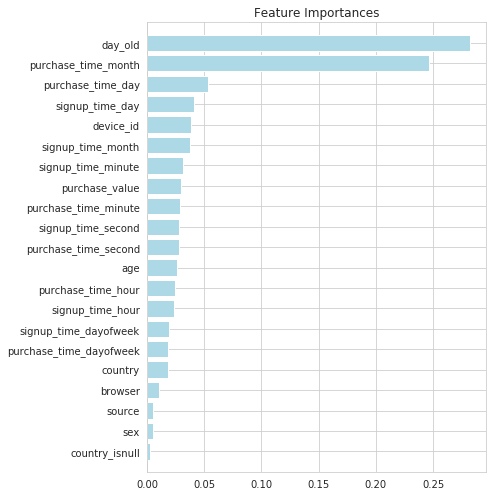

In [12]:
plot_feature_importances_rf(rf.feature_importances_,col_names,figsize=(7,7))

## Finetuning

In [4]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])

Process:device_id
Process:source
Process:browser
Process:sex
Process:country


In [5]:
trn_idx,val_idx = get_cv_idxs(8)[0]

# baseline model
pred=np.array([1-np.mean(y[trn_idx]),np.mean(y[trn_idx])])
pred=np.tile(pred,(len(val_idx),1))
log_loss(y[val_idx],pred)
roc_auc_score(y[val_idx],pred[:,1])

0.20374610177494615

0.5

In [18]:
cv=get_cv_idxs(8)
params={
    'n_estimators':[13,14,15],
    'max_features':[0.75,0.8,0.85],
    'min_samples_leaf':[16,17,18,19],
    'class_weight':['balanced']
}

In [19]:
clf = gridsearch_rf(X,y,params,cv)

Best params: {'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'min_samples_split': 3, 'n_estimators': 15}
Best score: -0.2726329150120758
Train AUC: 0.9984877301885088. Train Log loss: 0.183275909714228
Val AUC: 0.5368013648389804. Val Log loss: 0.2726329150120758


In [16]:
clf = gridsearch_rf(X,y,params,cv)

Best params: {'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 15}
Best score: -0.2726329150120758
Train AUC: 0.9984877301885088. Train Log loss: 0.183275909714228
Val AUC: 0.5368013648389804. Val Log loss: 0.2726329150120758


In [10]:
clf = gridsearch_rf(X,y,params,cv)

Best params: {'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14}
Best score: 0.5397017677883907
Train AUC: 0.998140067132129. Train Log loss: 0.1833456333381031
Val AUC: 0.5397017677883907. Val Log loss: 0.27336447253366514


In [38]:
clf = gridsearch_rf(X,y,params,cv)

Best params: {'class_weight': 'balanced', 'max_features': 0.7, 'min_samples_leaf': 18, 'n_estimators': 15}
Best score: 0.5321906090045421
Train AUC: 0.9981306639963324. Train Log loss: 0.1889436664772975
Val AUC: 0.5321906090045421. Val Log loss: 0.2757251931498456


In [6]:
best_params={'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14}
rf = train_rf(X,y,X,y,best_params)

Train AUC: 0.9980571096521454. Train Log loss: 0.18545807505291548
Val AUC: 0.9980571096521453. Val Log loss: 0.18545807505291548


In [15]:
def metric(rf,X,y):
    y_pred = rf.predict_proba(X)[:,1]
    return roc_auc_score(y,y_pred)
X_df = pd.DataFrame(X,columns = col_names)

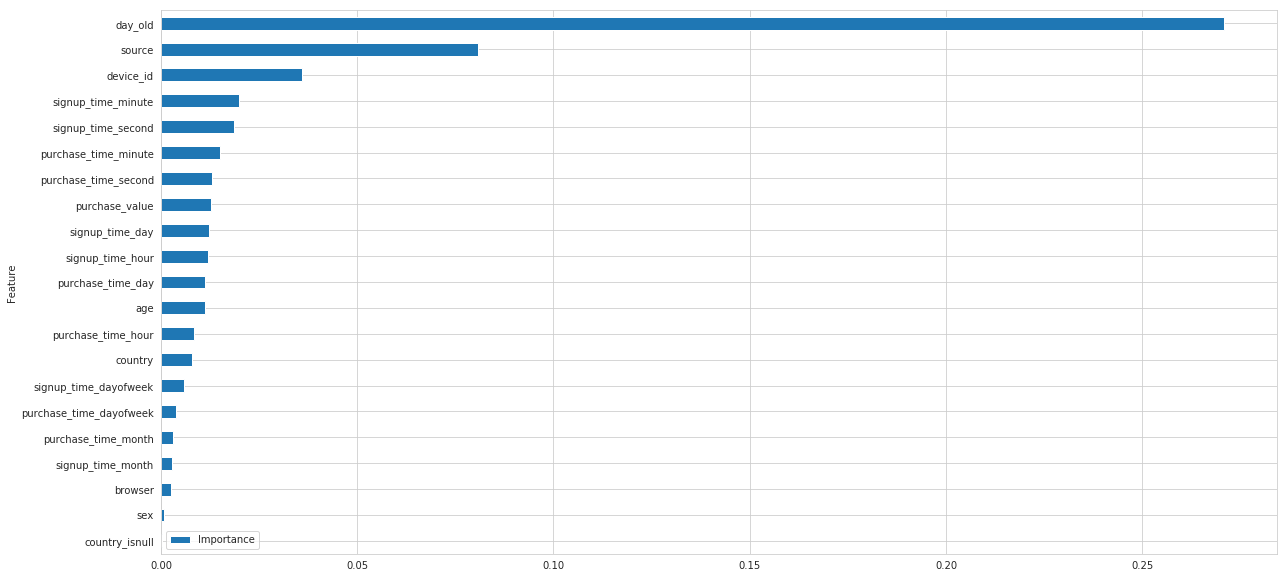

In [17]:
_=permutation_importances(rf,X_df,y,metric)

## Low depth tree plotting

In [96]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])

Process:device_id
Process:source
Process:browser
Process:sex
Process:country


In [97]:
best_params={'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14,'max_depth':6}
rf = train_rf(X,y,X,y,best_params)

Train AUC: 0.8129263437609743. Train Log loss: 0.38729498201026147
Val AUC: 0.8129263437609743. Val Log loss: 0.38729498201026147


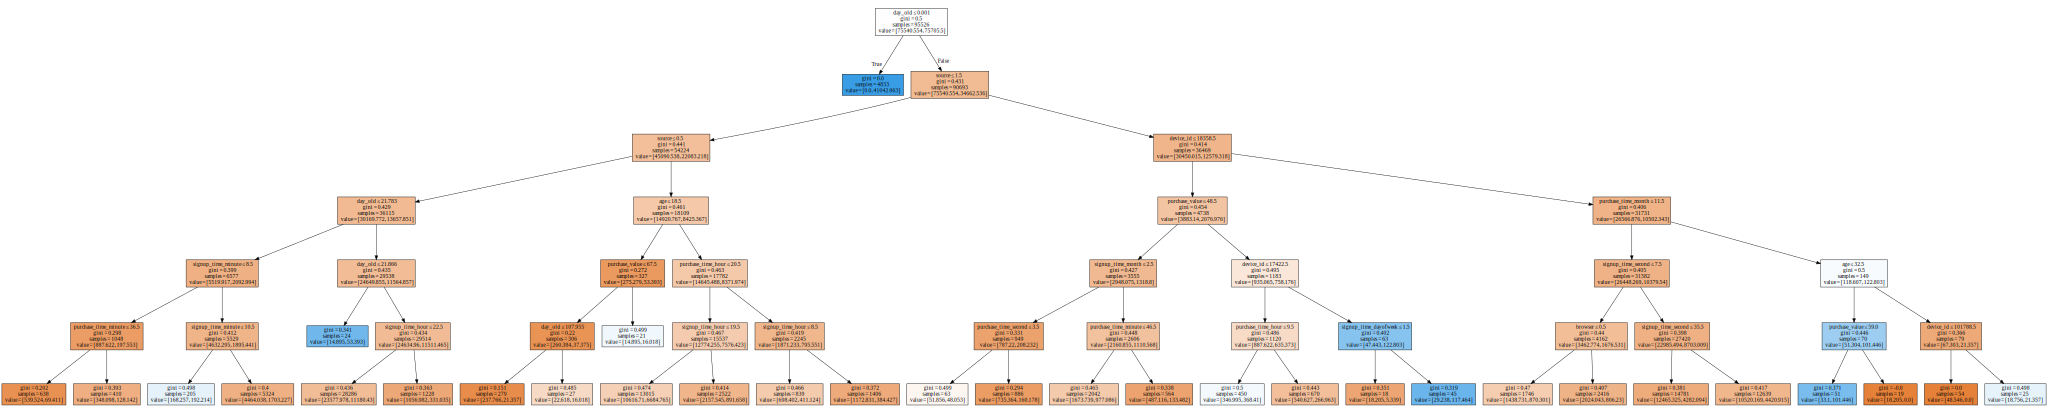

In [73]:
draw_tree(rf.estimators_[0],col_names,size=30,ratio=0.2,precision=3,rotate=False)

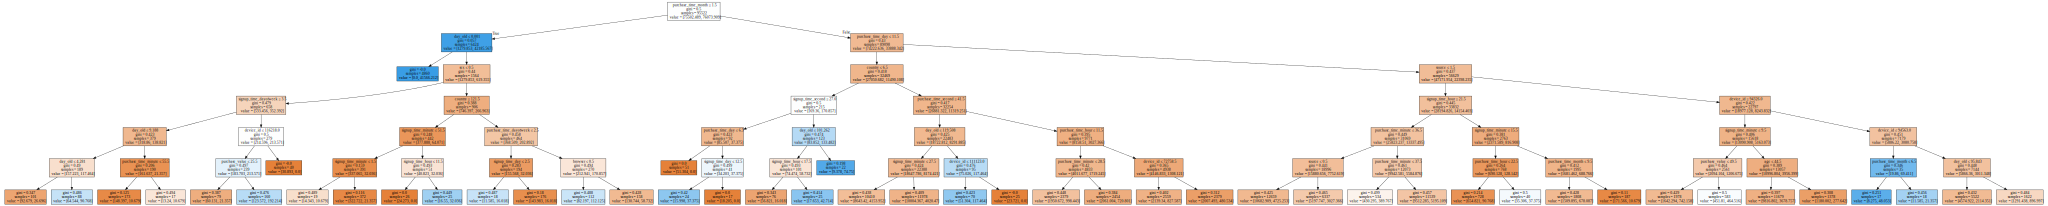

In [101]:
draw_tree(rf.estimators_[6],col_names,size=50,ratio=0.1,precision=3,rotate=False)

As expected, day_old is one of most obvious features used to determine fraud, as every subtree of random forest uses this feature to split from the beginning

We can see that sometimes decision trees try to split a feature twice near the root ('source' or 'device id'). This might indicate that these features can be break down further in feature engineering process. There are some interactions between feature 'device_id' and 'day_old' or 'source' and 'device'. We can make this model job easier by doing some feature engineering on these features together (such as generating all pairs of two features and perform mean encoding). This will help Random Forest run faster and make it easier to interpret.

# Extrapolation

The idea to extend this random forest model to an unknown situation by assuming that existing trends will continue. Random Forest uses all of its features for prediction and sometimes some time-series features might not capture the trend. For example, using old data might hurt model performance as old data might not capture current or future trend. 

One way to fix this problems is to identify and avoid using these features. If there is something else other than time that can predict well, the model will generalize with future data. This is also a way to remove redundant time-related features, thus make model less sensitive to time and generalize.


## Get features that can determine future (validation) data

In [59]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])

Process:device_id
Process:source
Process:browser
Process:sex
Process:country


In [46]:
best_params={'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14}
rf = train_rf(X,y,X,y,best_params)

Train AUC: 0.9980571096521454. Train Log loss: 0.18545807505291548
Val AUC: 0.9980571096521454. Val Log loss: 0.18545807505291548


In [60]:
train_idx,val_idx = get_cv_idxs(8)[-1]

In [61]:
X_df = pd.DataFrame(X,columns = col_names)

In [62]:
X_df['valid']=1
X_df.loc[train_idx]=0
y_ex = X_df.valid
X_df.drop('valid',axis=1,inplace=True)

In [63]:
params={'max_features': 0.5, 
        'min_samples_leaf': 3, 
        'n_estimators': 30,
        'oob_score':True,
       'random_state':42}
rf_ex = RandomForestClassifier(**params)

In [64]:
rf_ex.fit(X_df,y_ex)
rf_ex.oob_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

1.0

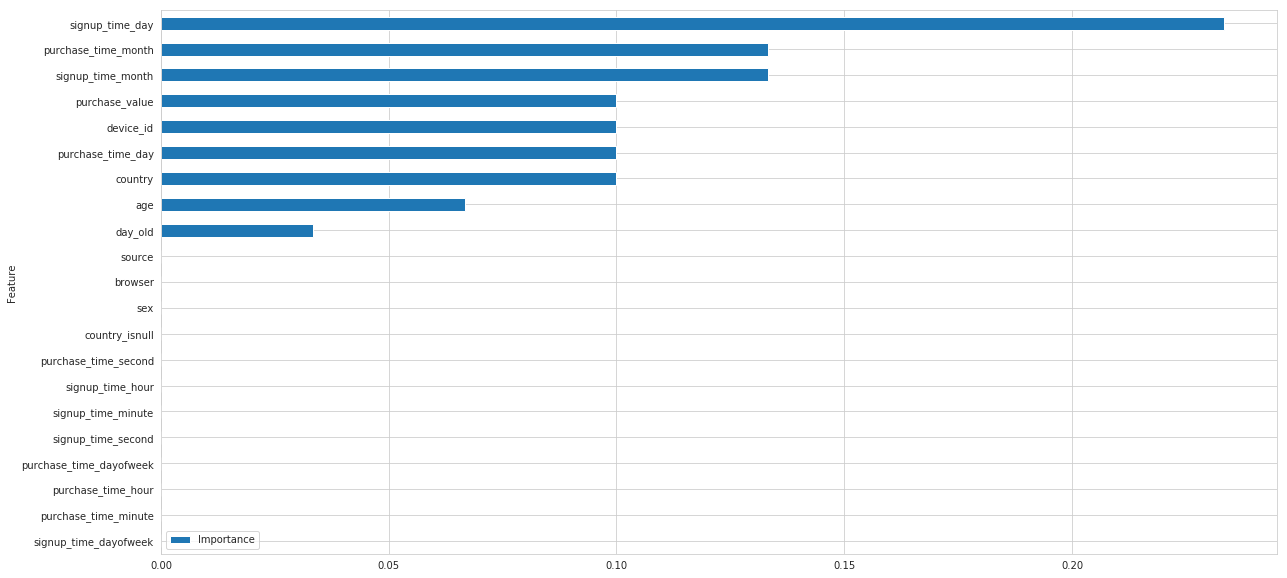

In [65]:
fea_df=plot_feature_importances_rf(rf_ex.feature_importances_,X_df.columns.values)

In [66]:
fea_df.index.values[-3:]

array(['signup_time_month', 'purchase_time_month', 'signup_time_day'],
      dtype=object)

In [67]:
X_df.drop(fea_df.index[-3:].tolist(),axis=1,inplace=True)

In [68]:
params={'max_features': 0.5, 
        'min_samples_leaf': 3, 
        'n_estimators': 30,
        'oob_score':True,
       'random_state':42}
rf_ex = RandomForestClassifier(**params)

rf_ex.fit(X_df,y_ex)
rf_ex.oob_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

1.0

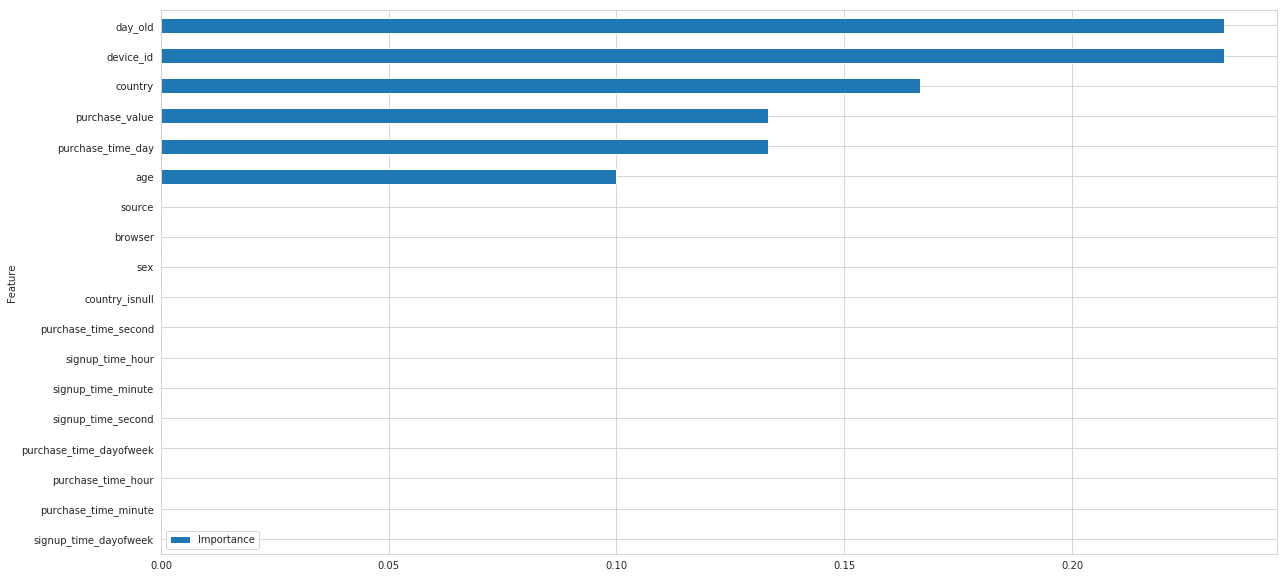

In [69]:
fea_df=plot_feature_importances_rf(rf_ex.feature_importances_,X_df.columns.values)

In [70]:
X_df.drop(fea_df.index.values[-2:],axis=1,inplace=True)
X_df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'country',
       'signup_time_dayofweek', 'signup_time_hour', 'signup_time_minute',
       'signup_time_second', 'purchase_time_day', 'purchase_time_dayofweek',
       'purchase_time_hour', 'purchase_time_minute', 'purchase_time_second',
       'country_isnull'],
      dtype='object')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

1.0

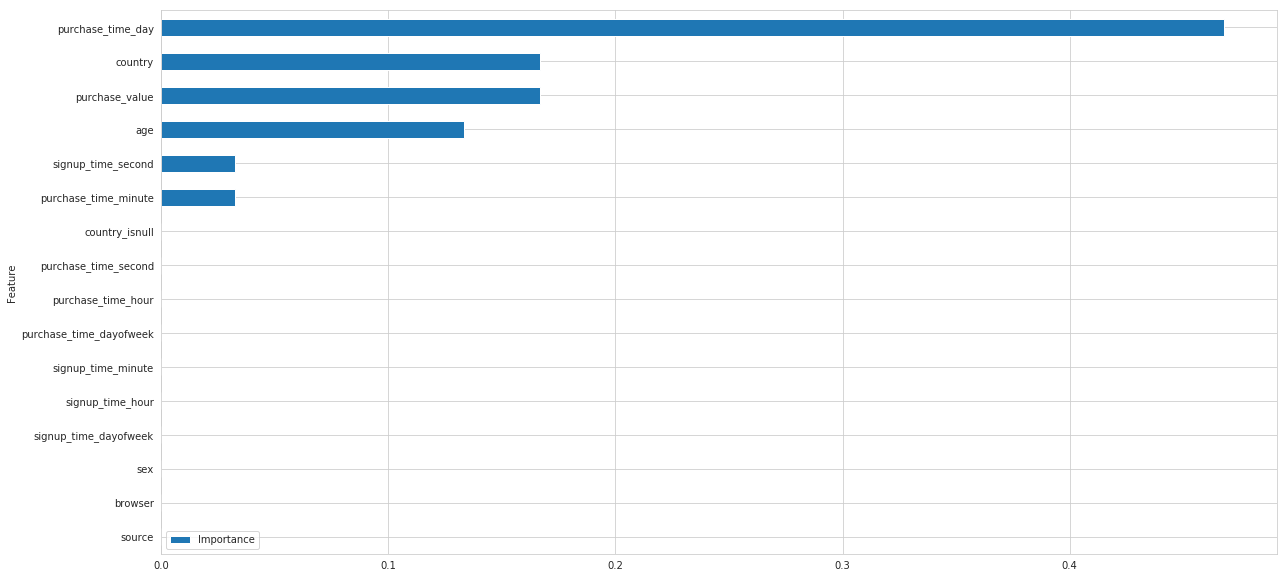

In [71]:
params={'max_features': 0.5, 
        'min_samples_leaf': 3, 
        'n_estimators': 30,
        'oob_score':True,
       'random_state':42}
rf_ex = RandomForestClassifier(**params)

rf_ex.fit(X_df,y_ex)
rf_ex.oob_score_

fea_df=plot_feature_importances_rf(rf_ex.feature_importances_,X_df.columns.values)

## Which one of these are the least significant?

In [85]:
cols_to_drop=['signup_time_month', 'purchase_time_month', 'signup_time_day','purchase_time_day','day_old','device_id']

In [4]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])
train_idx,val_idx = get_cv_idxs(8)[-1]

Process:device_id
Process:source
Process:browser
Process:sex
Process:country


In [5]:
X_df = pd.DataFrame(X,columns = col_names)

In [83]:
# with all columns
best_params={'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14}
rf = train_rf(X_df.loc[train_idx],y[train_idx],X_df.loc[val_idx],y[val_idx],best_params)

Train AUC: 0.9981400671321289. Train Log loss: 0.1833456333381031
Val AUC: 0.5397017677883907. Val Log loss: 0.27336447253366514


In [86]:
for col in cols_to_drop:
    print(f'Drop {col}...')
    X_df_drop = X_df.drop(col,axis=1)
    _ = train_rf(X_df_drop.loc[train_idx],y[train_idx],X_df_drop.loc[val_idx],y[val_idx],best_params)      
    print('-'*10)

Drop signup_time_month...
Train AUC: 0.9980332464467838. Train Log loss: 0.1830474678957864
Val AUC: 0.49296380021652925. Val Log loss: 0.28023513162351366
----------
Drop purchase_time_month...
Train AUC: 0.998037317038338. Train Log loss: 0.18319275002449903
Val AUC: 0.5173760922555557. Val Log loss: 0.2759935923397543
----------
Drop signup_time_day...
Train AUC: 0.9980782083483022. Train Log loss: 0.18443695193234336
Val AUC: 0.509485666948539. Val Log loss: 0.28152473812179557
----------
Drop purchase_time_day...
Train AUC: 0.9979860563468805. Train Log loss: 0.18400453434373776
Val AUC: 0.4748586033542816. Val Log loss: 0.28460907054430806
----------
Drop day_old...
Train AUC: 0.9973896511533937. Train Log loss: 0.18688152087785354
Val AUC: 0.507148107931505. Val Log loss: 0.2828503254998175
----------
Drop device_id...
Train AUC: 0.9979027218427998. Train Log loss: 0.18519915447875998
Val AUC: 0.48531831161634603. Val Log loss: 0.29179850562486304
----------


Unfortunately for this dataset, every time-related features are important; we can't remove any of them. We only have 1 year of data to work with so we don't have to worry about any outdated data anyway

# Tree intepreter

In [27]:
from treeinterpreter import treeinterpreter as ti
import waterfall_chart
def interpret_row(rf,row,col_names,threshold=0.01):
    prediction, bias, contributions = ti.predict(rf, np.array([row]))
    print(f'Prediction: {prediction}')
    print(f'Bias: {bias}')
    contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]
    _=waterfall_chart.plot(col_names,contributions, rotation_value=90, threshold = threshold,formatting='{:,.2f}')

In [25]:
cat_cols=['device_id','source','browser','sex','country']
X,y,cat_class,col_names= prepare_data_rf(cat_cols,['country'])
train_idx,val_idx = get_cv_idxs(8)[-1]

# X_df = pd.DataFrame(X,columns = col_names)

best_params={'class_weight': 'balanced', 'max_features': 0.8, 'min_samples_leaf': 17, 'n_estimators': 14}
rf = train_rf(X,y,X,y,best_params)

Process:device_id
Process:source
Process:browser
Process:sex
Process:country
Train AUC: 0.9980571096521454. Train Log loss: 0.18545807505291548
Val AUC: 0.9980571096521453. Val Log loss: 0.18545807505291548


In [26]:
X_df = pd.DataFrame(X,columns = col_names)

In [6]:
X_df.head()

,purchase_value,device_id,source,browser,sex,age,country,day_old,signup_time_day,signup_time_month,...,signup_time_hour,signup_time_minute,signup_time_second,purchase_time_day,purchase_time_month,purchase_time_dayofweek,purchase_time_hour,purchase_time_minute,purchase_time_second,country_isnull
0,14.0,5699.0,0.0,0.0,0.0,38.0,88.0,83.480835,1.0,1.0,...,0.0,0.0,42.0,25.0,3.0,2.0,11.0,33.0,6.0,0.0
1,14.0,5699.0,0.0,0.0,0.0,38.0,88.0,0.000012,1.0,1.0,...,0.0,0.0,43.0,1.0,1.0,3.0,0.0,0.0,44.0,0.0
2,14.0,5699.0,0.0,0.0,0.0,38.0,88.0,0.000012,1.0,1.0,...,0.0,0.0,44.0,1.0,1.0,3.0,0.0,0.0,45.0,0.0
3,14.0,5699.0,0.0,0.0,0.0,38.0,88.0,0.000012,1.0,1.0,...,0.0,0.0,45.0,1.0,1.0,3.0,0.0,0.0,46.0,0.0
4,14.0,5699.0,0.0,0.0,0.0,38.0,88.0,0.000012,1.0,1.0,...,0.0,0.0,46.0,1.0,1.0,3.0,0.0,0.0,47.0,0.0


Let say we are interested in the first and last fraud records of the year and want to know how these 2 records are fraud

In [35]:
fraud = X_df[y==1].iloc[0]
fraud

purchase_value               14.000000
device_id                  5699.000000
source                        0.000000
browser                       0.000000
sex                           0.000000
age                          38.000000
country                      88.000000
day_old                       0.000012
signup_time_day               1.000000
signup_time_month             1.000000
signup_time_dayofweek         3.000000
signup_time_hour              0.000000
signup_time_minute            0.000000
signup_time_second           43.000000
purchase_time_day             1.000000
purchase_time_month           1.000000
purchase_time_dayofweek       3.000000
purchase_time_hour            0.000000
purchase_time_minute          0.000000
purchase_time_second         44.000000
country_isnull                0.000000
Name: 1, dtype: float32

Prediction: [[0. 1.]]
Bias: [[0.50020275 0.49979725]]


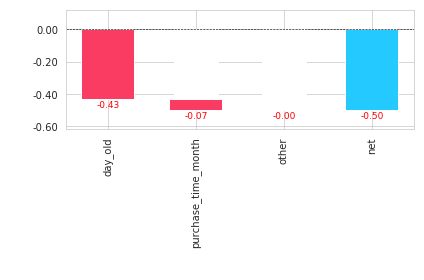

In [36]:
interpret_row(rf,fraud.values,col_names)

From this waterflow chart, day_old is the main factor that makes this account fraud

purchase_value                 24.000000
device_id                  134731.000000
source                          0.000000
browser                         2.000000
sex                             0.000000
age                            35.000000
country                       172.000000
day_old                        35.426632
signup_time_day                18.000000
signup_time_month               8.000000
signup_time_dayofweek           1.000000
signup_time_hour                3.000000
signup_time_minute             25.000000
signup_time_second             36.000000
purchase_time_day              22.000000
purchase_time_month             9.000000
purchase_time_dayofweek         1.000000
purchase_time_hour             13.000000
purchase_time_minute           39.000000
purchase_time_second           57.000000
country_isnull                  0.000000
Name: 151076, dtype: float32

Prediction: [[0.45753508 0.54246492]]
Bias: [[0.50020275 0.49979725]]


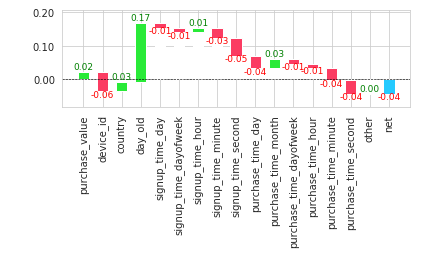

In [52]:
fraud = X_df[y==1].iloc[-2]
fraud

interpret_row(rf,fraud.values,col_names,threshold=0.05)

Random Forest has some difficulty trying to determine this record as it s only 54% sure this is a fraud. Main factors to are device id and combination of purchase time + signup time

Let's take a look a one nonfraud id

purchase_value                43.000000
device_id                  77180.000000
source                         2.000000
browser                        2.000000
sex                            0.000000
age                           33.000000
country                      172.000000
day_old                      105.505867
signup_time_day                1.000000
signup_time_month              1.000000
signup_time_dayofweek          3.000000
signup_time_hour               0.000000
signup_time_minute             5.000000
signup_time_second            19.000000
purchase_time_day             16.000000
purchase_time_month            4.000000
purchase_time_dayofweek        3.000000
purchase_time_hour            12.000000
purchase_time_minute          13.000000
purchase_time_second          46.000000
country_isnull                 0.000000
Name: 11, dtype: float32

Prediction: [[0.84685406 0.15314594]]
Bias: [[0.50020275 0.49979725]]


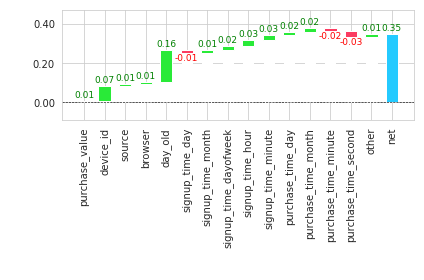

In [57]:
nfraud = X_df[y==0].iloc[1]
nfraud

interpret_row(rf,nfraud.values,col_names,threshold=0.05)

RF did a good job on this one. Main factors to decide this record as nonfraud are day_old and device_id